In [1]:
# Local imports from the environment file
from Environment import BasicEnv
from stable_baselines3.common.env_checker import check_env
# import rl_utils

# Other useful imports
import matplotlib.pyplot as plt
import random
import numpy as np
from IPython.display import clear_output
import pandas as pd

In [2]:
# environment checker for compatibility with stablebaselines3 (RL algorithm library)
# The check_env is not a compulsory step. It is just a step to check that our environment is correct and well defined
# i.e. A step and reset function well defined, a well defined numerical reward etc...
env = BasicEnv(waiting_period=45)
check_env(env)

We are changing the CPU request. Careful here!!!: OLD CPU: 200, new CPU: 116


In [3]:
# Define state space boundaries
x_min, x_max = env.observation_space.low[0], env.observation_space.high[0]
y_min, y_max = env.observation_space.low[1], env.observation_space.high[1]

# Calculate the range for each dimension
x_range = x_max - x_min + 1
y_range = y_max - y_min + 1


def state_to_index(x, y):
    return (y-x)/100 + 40


def index_to_state(index):
    pass


In [5]:
def round_CPU_values(state:list):
    # Function to round all cpu values to the nearest hundred.
    # It takes the current state (actual and allocated CPU) as parameter
    new_actual_CPU = int(round(state[0],-2))
    new_requested_CPU = int(round(state[1],-2))
    reduced_state = [new_actual_CPU, new_requested_CPU]
    return reduced_state

In [13]:
# Get all states in one set to be be able to count the number of states and create q-table
set_values = set()

for i in range(int(x_min), int(x_max+1)):
    for j in range(int(y_min),int(y_max+1)):
        set_values.add(state_to_index(round_CPU_values([i,j])[0], round_CPU_values([i,j])[1]))

val_range = len(set_values)
print(f"new states-space dimension: {val_range}, ")
print(set_values)

new states-space dimension: 81, 
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0}


In [14]:
observation_space_range = len(set_values)
print(observation_space_range,)

81


In [15]:
q_table = np.zeros((int(observation_space_range), env.action_space.n))
print(q_table.shape)

(81, 7)


In [16]:
print(f"Q-table size:{q_table.size}, Q-table zero cells:{q_table.size - np.count_nonzero(q_table)}, Q-table non zero cells:{np.count_nonzero(q_table)}, Q-table zero cells ratio:{(q_table.size - np.count_nonzero(q_table))/q_table.size}")

Q-table size:567, Q-table zero cells:567, Q-table non zero cells:0, Q-table zero cells ratio:1.0


In [17]:
# Hyperparameters
training_episodes = 500 # Total number of episodes
lr = 0.2 # Learning rate
gamma = 0.4 # Discount factor
exploration_proba = 1
exploration_decreasing_decay = 0.001
min_exploration_proba = 0.001

In [18]:
# Training
number_explore = 0
number_exploit = 0

reward_array = []
xs = []
requested_CPU_array = []
actual_CPU_array = []

for i in range(0, training_episodes):
    current_state, info = env.reset() 

    # epochs, penalties = 0, 0
    terminated = False
    
    while not terminated:
        
        reduced_current_state = round_CPU_values(current_state)
        encoded_current_state = int(state_to_index(int(reduced_current_state[0]), int(reduced_current_state[1])))
        
        
        if random.uniform(0, 1) < exploration_proba:
            action = env.action_space.sample() # Explore action space
            number_explore+=1
        else:
            action = np.argmax(q_table[encoded_current_state]) # Exploit learned values
            number_exploit+=1

        next_state, reward, terminated, truncated, info = env.step(action)
        
        old_value = q_table[encoded_current_state, action]
        reduced_next_state = round_CPU_values(next_state)
        encoded_next_state = int(state_to_index(int(reduced_next_state[0]), int(reduced_next_state[1])))
        # encoded_next_state = int(state_to_index(int(next_state[0]), int(next_state[1])))
        next_max = np.max(q_table[encoded_next_state])
        
        q_table[encoded_current_state, action] = (1 - lr) * old_value + lr * (reward + gamma * next_max)
        reward_array.append(reward)
        requested_CPU_array.append(current_state[1])
        actual_CPU_array.append(current_state[0])
        xs.append(i+1)
        print(current_state, current_state[0], current_state[1])

        current_state = next_state
        
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*i))
    
    # if i % 100 == 0:
    #     clear_output(wait=True)
    #     print(f"Episode: {i}")
clear_output(wait=True)
print()
print(f"===========================================")
print(f"Training finished.")
print(f"{i+1} Training episodes completed. \n")
print(f"explorations:{number_explore}, exploitation:{number_exploit}, exploration_proba at the end:{exploration_proba}")
print("Exploration_probability at the end of the training: ", exploration_proba)


Training finished.
500 Training episodes completed. 

explorations:389, exploitation:111, exploration_proba at the end:0.6071374937387897
Exploration_probability at the end of the training:  0.6071374937387897


In [19]:
print(f"===========================================")
print(f"Training finished.")
print(f"{i+1} Training episodes completed. \n")
print(f"explorations:{number_explore}, exploitation:{number_exploit}, exploration_proba at the end:{exploration_proba}")
print("Exploration_probability at the end of the training: ", exploration_proba)
print(f"Q-table size:{q_table.size}, Q-table zero cells:{q_table.size - np.count_nonzero(q_table)}, Q-table non zero cells:{np.count_nonzero(q_table)}, Q-table zero cells ratio:{(q_table.size - np.count_nonzero(q_table))/q_table.size}")
print(f"Exploration Rate:{number_explore/(number_explore+number_exploit)}, Exploitation Rate:{number_exploit/(number_explore+number_exploit)}")


Training finished.
500 Training episodes completed. 

explorations:389, exploitation:111, exploration_proba at the end:0.6071374937387897
Exploration_probability at the end of the training:  0.6071374937387897
Q-table size:567, Q-table zero cells:481, Q-table non zero cells:86, Q-table zero cells ratio:0.8483245149911817
Exploration Rate:0.778, Exploitation Rate:0.222


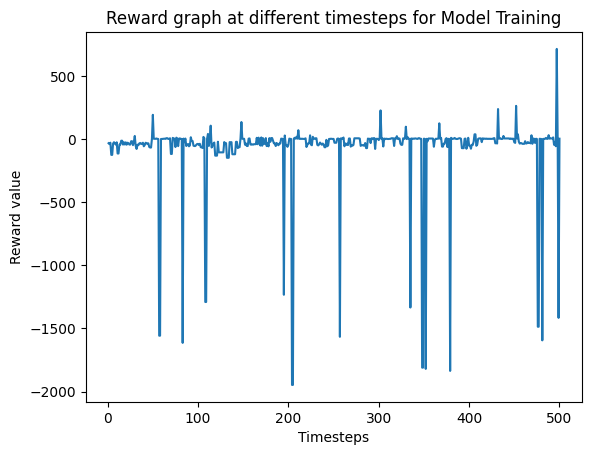

In [20]:
plt.plot(xs, reward_array)
plt.xlabel("Timesteps")
plt.ylabel("Reward value")
plt.title("Reward graph at different timesteps for Model Training")
plt.show()

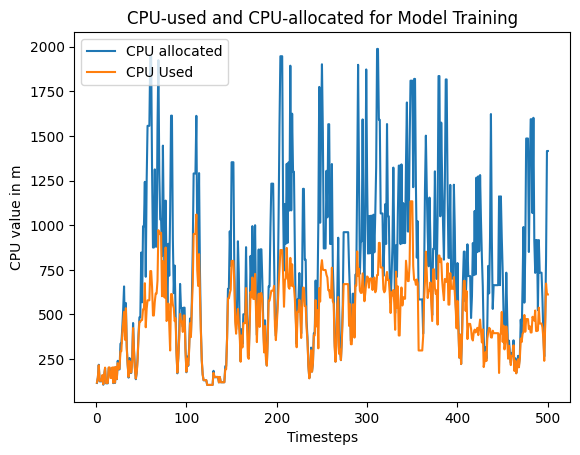

In [21]:
plt.plot(xs, requested_CPU_array, label = "CPU allocated")
plt.plot(xs, actual_CPU_array, label = "CPU Used")
plt.xlabel("Timesteps")
plt.ylabel("CPU value in m")
plt.title("CPU-used and CPU-allocated for Model Training")
plt.legend()
plt.show()

# Model Evaluation

In [22]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_rewards, total_penalties, total_num_of_penalties, total_num_of_rewards = 0, 0, 0, 0, 0
evaluation_episodes = 100
reward_array = []
xs = []
requested_CPU_array = []
actual_CPU_array = []

for _ in range(evaluation_episodes):
    current_state, info = env.reset()
    
    # epochs, penalties, num_rewards, reward = 0, 0, 0, 0
    
    terminated = False
    
    while not terminated:
        reduced_current_state = round_CPU_values(current_state)
        encoded_current_state = int(state_to_index(int(reduced_current_state[0]), int(reduced_current_state[1])))
        # encoded_current_state = int(state_to_index(int(current_state[0]), int(current_state[1])))
        action = np.argmax(q_table[encoded_current_state])
        current_state, reward, terminated, truncated, info = env.step(action)
        reward_array.append(reward)
        requested_CPU_array.append(current_state[1])
        actual_CPU_array.append(current_state[0])
        xs.append(_+1)

        # if reward < 0:
            # penalties += 1
            # total_penalties+=reward
        # else:
            # num_rewards += 1
            # total_rewards += reward


clear_output(wait=True)
# print()
# print(f"===========================================")
# print(f"Evaluation finished.")
# print(f"{i+1} Evaluation episodes completed. \n")
# print(f"Results after {episodes} episodes:")

We are changing the CPU request. Careful here!!!: OLD CPU: 200, new CPU: 949

initial state:[531 949]
Trying to delete and recreate topics
Trying to recreate a new pod...
We are changing the CPU request. Careful here!!!: OLD CPU: 949, new CPU: 760
Pod is not ready
1 Remove-miliCPU-by-20 [531 949] [558 760] 11.06194690265487 11.06194690265487
We are changing the CPU request. Careful here!!!: OLD CPU: 200, new CPU: 760

initial state:[558 760]
Trying to delete and recreate topics
Trying to recreate a new pod...
We are changing the CPU request. Careful here!!!: OLD CPU: 760, new CPU: 1140
1 Add-miliCPU-by-1.5 [558 760] [ 496 1140] 1.8355359765051393 1.8355359765051393
We are changing the CPU request. Careful here!!!: OLD CPU: 200, new CPU: 1140

initial state:[ 496 1140]
Trying to delete and recreate topics
Trying to recreate a new pod...
We are changing the CPU request. Careful here!!!: OLD CPU: 1140, new CPU: 912
1 Remove-miliCPU-by-20 [ 496 1140] [541 912] 3.8051750380517495 3.80517503

In [23]:
print()
print(f"===========================================")
print(f"Evaluation finished.")
print(f"{_+1} Evaluation episodes completed. \n")
print(f"Results after {evaluation_episodes} episodes:")
print(f"Mean CPU usage: {np.mean(actual_CPU_array)}")
print(f"Mean CPU alloc: {np.mean(requested_CPU_array)}")
print(f"Mean rewards {np.mean(reward_array)}")


Evaluation finished.
100 Evaluation episodes completed. 

Results after 100 episodes:
Mean CPU usage: 468.42
Mean CPU alloc: 790.28
Mean rewards 4.648142731645848


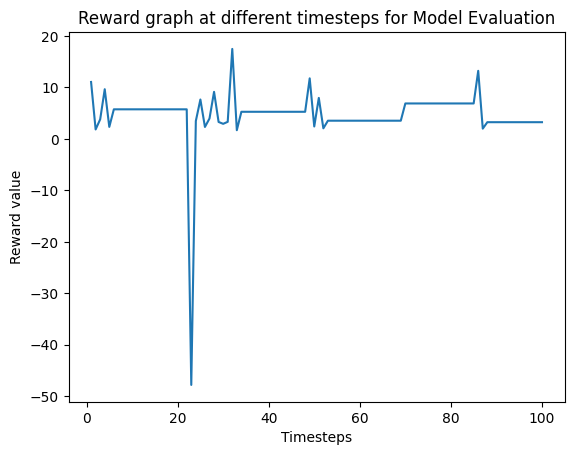

In [24]:
plt.plot(xs, reward_array)
plt.xlabel("Timesteps")
plt.ylabel("Reward value")
plt.title("Reward graph at different timesteps for Model Evaluation")
plt.show()

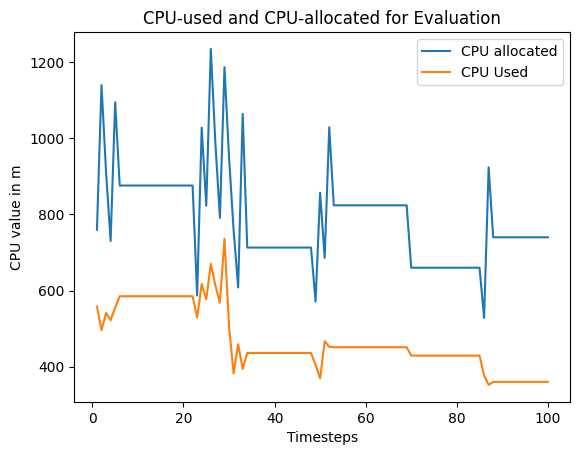

In [25]:
plt.plot(xs, requested_CPU_array, label = "CPU allocated")
plt.plot(xs, actual_CPU_array, label = "CPU Used")
plt.xlabel("Timesteps")
plt.ylabel("CPU value in m")
plt.title("CPU-used and CPU-allocated for Evaluation")
plt.legend()
plt.show()

In [26]:
reduced_state = round_CPU_values(env.state)
encoded_state = state_to_index(reduced_state[0],reduced_state[1])
print(f"original_state: {env.state}, reduced_state: {reduced_state}, encoded_state: {encoded_state}")
print(q_table[int(encoded_state)])

original_state: [360 740], reduced_state: [400, 700], encoded_state: 43.0
[   8.69781757    7.69334691    4.23406895 -187.89378961  -13.47013631
  -13.44876637    1.49395343]


# Dumping Q-table

In [27]:
# pd.DataFrame(q_table).to_csv("q_table_run_17.csv")

# Loading Q-Table

In [28]:
# # If loading q_table from csv file, make sure to drop the first (index) column.
# # If not, this index column will be in your columns and will trouble your results
# # as it will act as an action column
# df_q_table = pd.read_csv('q_table_run_13.csv',header=None)
# df_q_table.drop(labels=0,axis=1,inplace=True)
# q_table = df_q_table.to_numpy()
# print(np.nonzero(q_table))
# len(q_table[6])